In [2]:
# !pip install qutip

from math import *
import itertools
from itertools import product
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from qutip import *

font = {'size'   : 17}

matplotlib.rc('font', **font)
# matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 15, 4
plt.rcParams['figure.dpi'] = 60
matplotlib.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
 

# Creating Hamiltonian

In [3]:
def imp_energy(Ek_0, V, U):
    dim = len(Ek_0)
    tau = create(2)*destroy(2) - 1/2
    imp_U = [tau, tau]
    bath = [identity(2)]*2*dim
    return U*tensor(imp_U+bath)


def kin_en(Ek_0, V, U):
    H = 0
    tau = create(2)*destroy(2) - 1/2
    dim = len(Ek_0)
    for i in range(dim):
        H += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [tau, identity(2)] + [identity(2)]*2*(dim - i - 1)))
        H += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), tau] + [identity(2)]*2*(dim - i - 1)))
    return H


def hyb(Ek_0, V, U):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        H += V * tensor([create(2), identity(2)] + [identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(Nk - 1 - i)) + V * tensor([identity(2), create(2)] + [identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(Nk - 1 - i))
        H -= V * tensor([destroy(2), identity(2)] + [identity(2)]*2*i + [create(2), identity(2)] + [identity(2)]*2*(Nk - 1 - i)) + V * tensor([identity(2), destroy(2)] + [identity(2)]*2*i + [identity(2), create(2)] + [identity(2)]*2*(Nk - 1 - i))
    return H

# Spectral Function: $T=0$

100%|██████████| 65536/65536 [00:00<00:00, 1148003.29it/s]


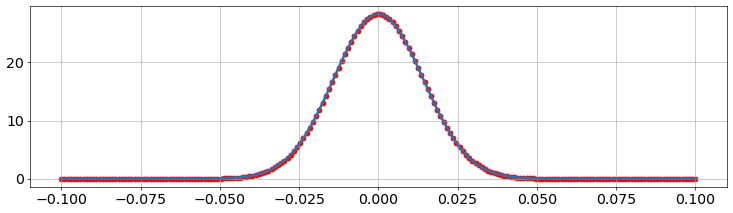

100%|██████████| 32768/32768 [00:00<00:00, 1254233.92it/s]


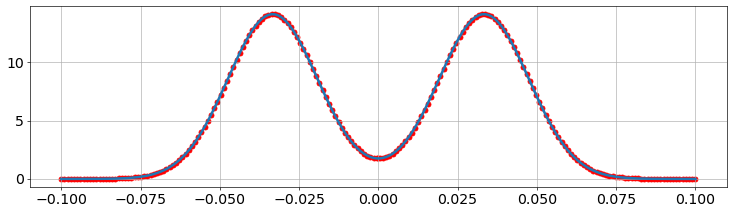

100%|██████████| 32768/32768 [00:00<00:00, 1212668.11it/s]


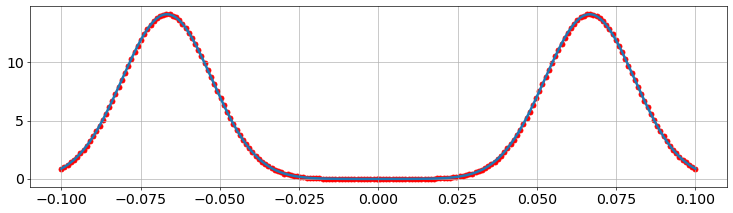

100%|██████████| 32768/32768 [00:00<00:00, 1117108.32it/s]


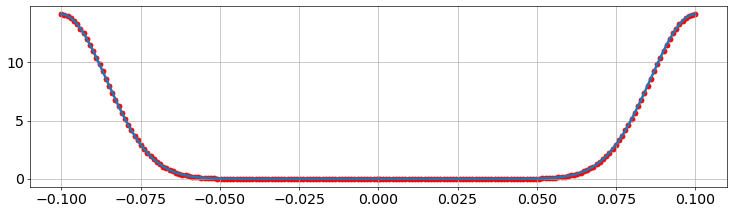

43.21118211746216


In [15]:
import time

def get_rho_X(args):
    (En, Xn), Xgs = args
    eta = 2*max(Ek_0)
    N = len(Xgs.dims[0])
    Z = len(X0)
    Egs = E[0]
    c0_up = tensor([destroy(2), identity(2)] + [identity(2)]*(N-2))
    C1 = Xgs.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*Xgs
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    x1 = w_range + Egs - En
    x2 = w_range + En - Egs
    return (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z

start = time.time()
for U in np.linspace(0, 0.2, 4):
    V = 10**(-2)
    Nk = 4
    a = 1
    k_bath = 2*np.pi*np.arange(Nk)/((Nk)*a)
    Ek_0 = V*np.cos(k_bath*a)
    len_w = 100
    w_end = 10*V
    w_range = np.linspace(-w_end, w_end, 2*len_w)
    w_range = np.insert(w_range, int(len_w), 0) if 0 not in w_range else w_range

    H = 0
    H += kin_en(Ek_0, V, U)
    H += imp_energy(Ek_0, V, U)
    H += hyb(Ek_0, V, U)
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    E0 = E[np.where(E == min(E))]
    X0 = X[np.where(E == min(E))]
    Z = len(E0)
    
    A = sum(tqdm(Pool(processes=7).map(get_rho_X, product(zip(E, X), X0)), total=len(X0)*len(E)))
    
    # if A[np.where(w_range == 0)] > 10**(-5):
    #     A[np.where(w_range == 0)] = 30
    #     A[np.where(w_range == 0)[0] - 1] = (A[np.where(w_range == 0)] + A[np.where(w_range == 0)[0] - 1])/2
    #     A[np.where(w_range == 0)[0] + 1] = (A[np.where(w_range == 0)] + A[np.where(w_range == 0)[0] + 1])/2

    plt.plot(w_range, A)
    plt.scatter(-w_range, A, color='red')
    plt.show()

stop = time.time()
print (stop - start)

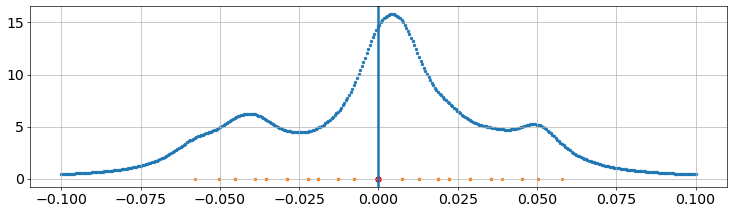

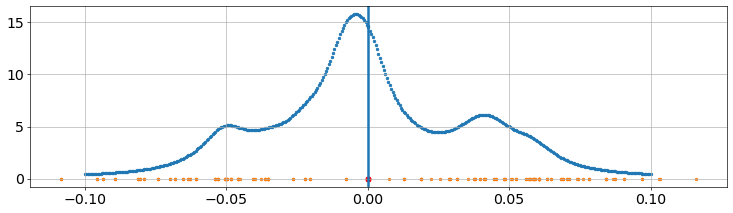

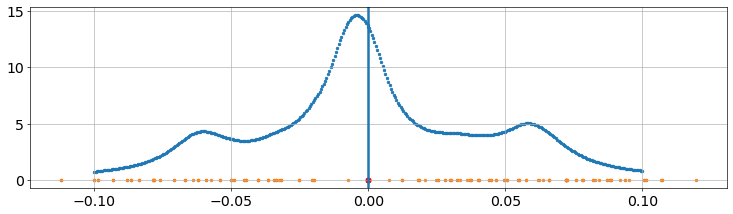

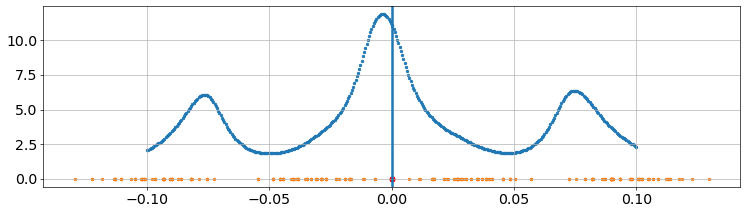

In [40]:
def rho_at_w(args):
    (En, Xn), Xgs, w = args
    eta = max(Ek_0)/2
    Z = len(X0)
    Egs = E[0]
    c0_up = tensor([destroy(2), identity(2)] + [identity(2)]*len(Ek_0)*2)
    C1 = Xgs.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*Xgs
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    x1 = w + Egs - En
    x2 = w + En - Egs
    # return w, (C1_sq * (eta/pi)/(eta**2 + x1**2) + C2_sq * (eta/pi)/(eta**2 + x2**2)) / Z
    return w, (C1_sq * exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z


for U in [0, 0.01, 0.05, 0.1]:
    # print (U)
    V = 10**(-2)
    Nk = 4
    a = 1
    k_bath = 2*np.pi*np.arange(Nk)/((Nk)*a)
    Ek_0 = -2*V*np.cos(k_bath*a)/sqrt(Nk)
    # Ek_0 = [-0.2, -0.1, 0.1, 0.2]
    len_w = 2*200
    w_end = 10*V
    w_range = np.linspace(-w_end, w_end, len_w)
    if 0 not in w_range:
        w_range = np.insert(w_range, int(len_w/2), [0])


    # H = 0
    # H += kin_en(Ek_0, V, U)
    # H += imp_energy(Ek_0, V, U)
    # H += hyb(Ek_0, V, U)
    # E, X = H.eigenstates()
    # E[np.where(abs(E)<10**(-10))] = 0
    # E0 = E[np.where(E == min(E))]
    # X0 = X[np.where(E == min(E))]
    # Z = len(E0)

    # A = w_range*0
    # poles = np.empty(0)
    # for (En, Xn), (Egs, Xgs) in product(zip(E, X), zip(E0, X0)):
    #     eta = max(Ek_0)
    #     Z = len(X0)
    #     c0_up = tensor([destroy(2), identity(2)] + [identity(2)]*len(Ek_0)*2)
    #     C1 = Xgs.dag()*c0_up*Xn
    #     C1_sq = np.real((C1*C1.dag())[0][0][0])
    #     C2 = Xn.dag()*c0_up*Xgs
    #     C2_sq = np.real((C2*C2.dag())[0][0][0])
    #     for i, w in enumerate(w_range):
    #         x1 = w + Egs - En
    #         x2 = w + En - Egs
    #         A[i] += (C1_sq * (eta/pi)/(eta**2 + x1**2) + C2_sq * (eta/pi)/(eta**2 + x2**2)) / Z

    #     # A = A + (C1_sq * (eta/pi)/(eta**2 + x1**2) + C2_sq * (eta/pi)/(eta**2 + x2**2)) / Z
    #     if C1_sq > 10**(-10) and En - Egs not in poles:
    #         poles = np.insert(poles, 0, En - Egs)
    #     if C2_sq > 10**(-10) and Egs - En not in poles:
    #         poles = np.insert(poles, 0, Egs - En)
    
    # # print (min(abs(poles)))
    # plt.scatter(w_range, A, marker=".")
    # poles[np.where(abs(poles) < 10**(-5))] = 0
    # plt.scatter(poles[np.where(poles != 0)], np.array(poles)[np.where(poles != 0)]*0, marker=".")
    # plt.scatter(poles[np.where(poles == 0)], np.array(poles)[np.where(poles == 0)]*0, marker="o", color='r')
    # plt.axvline(0, 0, 1)
    # plt.show()


    with Pool(processes=20) as p:
        rho_all = list(tqdm(p.imap(rho_at_w, product(zip(E[1:], X[1:]), X0, w_range)), total=len(w_range)*len(X0)*len(E[1:])))
    rho = w_range*0
    for rho_w in rho_all:
        rho[np.where(w_range==rho_w[0])] += rho_w[1]

    plt.scatter(w_range[np.where(rho > 10**(-10))], rho[np.where(rho > 10**(-10))], marker=".")
    plt.show()

# plt.show()

In [ ]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.5, 0.505, 0.005)

U = 0.0886301794495707
V = 0.006315372549557469
J = 0.03175939200139961

U0 = 0.09
J0 = 0.011
rho_1 = plot_A(U,V,J,U0,J0)


In [ ]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.5, 0.505, 0.005)
U = 0.14544161847480389
V = 0.01983202407440915
J = 0.11130436896180042
U0 = 0.15
J0 = 0.021

rho_3 = plot_A(U,V,J,U0,J0)

In [ ]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.75, 0.755, 0.005)
U = 0.29902982486011265
V = 0.01339673557864031
J = 0.24051449872105585
U0 = 0.3
J0 = 0.006

rho_2 = plot_A(U,V,J,U0,J0)

In [ ]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.75, 0.755, 0.01)
U = 0.39902982486011265
V = 0.01339673557864031
J = 0.34051449872105585
U0 = 0.3
J0 = 0.006

rho_2 = plot_A(U,V,J,U0,J0)

In [ ]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.5, 0.5, 0.005)
V = 0.006315372549557469
U0 = 0.3
J0 = 0.006
plt.rcParams["figure.figsize"]= 6, 3
for U,J in zip([0.3886301794495707, 0.1886301794495707,0.0886301794495707], [0.001175939200139961, 0.021175939200139961, 0.03175939200139961]):
    rho_2 = plot_A(U,V,J,U0,J0, title=False)

100%|██████████| 301/301 [09:43<00:00,  1.94s/it]


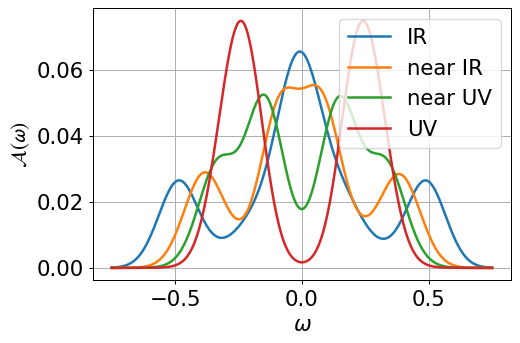

In [4]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.75, 0.755, 0.005)

V = 0.01339673557864031
U0 = 0.3
J0 = 0.006
U = 0.29
J = 0.24
rho1 = plot_A(U,V,J,U0,J0, show=False, title=False, label="IR")
U = 0.39
J = 0.14
rho2 = plot_A(U,V,J,U0,J0, show=False, title=False, label="near IR")
U = 0.43
J = 0.09
rho3 = plot_A(U,V,J,U0,J0, show=False, title=False, label="near UV")
U = 0.49
J = 0.04
rho4 = plot_A(U,V,J,U0,J0, show=False, title=False, label="UV")
plt.legend()
plt.rcParams["figure.figsize"]= 7, 9
plt.show()

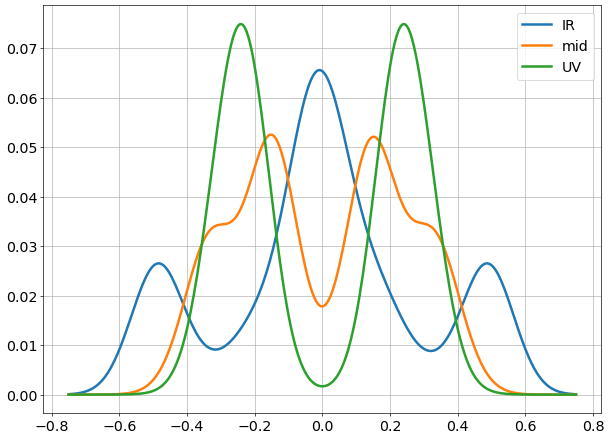

In [26]:
plt.plot(w_range, rho1, label="IR")
plt.plot(w_range, rho3, label="mid")
plt.plot(w_range, rho4, label="UV")
plt.legend()
plt.rcParams["figure.figsize"]= 12, 9
plt.show()

In [7]:
def rho_at_w(args):
    [Em, Emp],[Xm,Xmp] = args
    cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
    Vmmp = Xm.dag()*cdag_up*Xmp
    Vmmp_sq = np.real((Vmmp*Vmmp.dag())[0][0][0])
    x = w - Emp + Em
    eta = abs(max(Ek_0))      # width of broadening function
    return Vmmp_sq * exp(-(x/eta)**2)/(eta*sqrt(pi)) * (exp(-beta*Em) + exp(-beta*Emp)) / Z

Ek_0 = np.array([-0.2, -0.1, 0.1, 0.2])
# print (Ek_0)
U = 0.1
V = 0.019909015762077577
J = 0.015838964056748835
K = J
plt.rcParams["figure.figsize"]= 12, 4
H = kin_en(Ek_0, V, J, K, U)
# H += imp_energy(Ek_0, V, J, K, U)
H += hyb(Ek_0, V, J, K, U)
H += spin(Ek_0, V, J, K, U)
H += charge(Ek_0, V, J, K, U)
H = 0.5 * (H + H.dag())
E, X = H.eigenstates()
# E = np.array(E)
T = 0.1
kb = 1
beta = 1/(kb*T)
Z = sum(np.exp(-beta*E))
w_range = np.arange(-1, 1, 0.05)
rho = []
for w in tqdm(w_range):
    rho_w = sum(Pool(processes=10).map(rho_at_w, zip(product(E, E), product(X, X))))
    rho.append(rho_w)
    # for [Em, Emp],[Xm,Xmp] in zip(product(E, E), product(X, X)):
    #     cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
    #     Vmmp = Xm.dag()*cdag_up*Xmp
    #     Vmmp_sq = np.real((Vmmp*Vmmp.dag())[0][0][0])
    #     x = w - Emp + Em
    #     eta = Ek_0[-1]      # width of broadening function
    #     rho[-1] += Vmmp_sq * exp(-(x/w)**2)/(w*sqrt(pi)) * (exp(-beta*Em) + exp(-beta*Emp)) / Z    

plt.plot(w_range, rho)
plt.show()

TypeError: kin_en() missing 1 required positional argument: 'ed'